In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys; sys.path.append('../')
import torch
from functools import singledispatch, wraps
from inspect import getcallargs
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from asterism.base import buildmethod, checkmethod, Keynote
from asterism.utils import get_kwargs, kmeans
from asterism.utils.acts import Dirichlet
from asterism.utils.data import make_dataset
from asterism.utils.nets import ACT, OPTIM, Encoder, MLP
from asterism.utils.figs import show_dataset

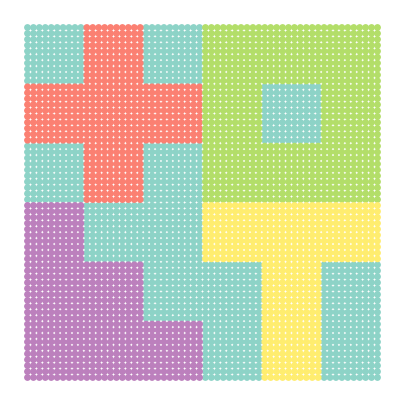

In [2]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

In [118]:
class RNN(nn.Module):
    def __init__(self, channels, act_layer='tanh', **kwargs):
        super().__init__()

        self.channels = channels

        self._model = MLP.layer(channels, channels)
        self._act_layer = ACT[act_layer](**kwargs)

    def forward(self, n_layers, state=None):
        if state is None:
            state = torch.zeros(1, self.channels)

        for i in range(1, n_layers + 1):
            state = torch.cat([state, self._model(state[i - 1:i])])

        return state[1:]
    
class RSB(Keynote, nn.Module):
    def __init__(self, min_topics=5, *, channels=(128, 32), kld_scale=.1, optim='adam', desc='RSB', seed=None):
        super().__init__(desc, seed)

        self.min_topics = min_topics
        self.channels = channels
        self.kld_scale = kld_scale
        self.optim = optim

        self._n_steps = 100

    def _build(self, X, learning_rate=1e-2, batch_size=128, shuffle=True):
        in_channels, self._batch_size, self.n_topics_ = X.shape[-1], batch_size, self.min_topics
        self._loader = DataLoader(X, batch_size, shuffle)
        self._encoder, self._dirichlet = Encoder(in_channels, *self.channels), Dirichlet()
        self._dt_model = RNN(self.channels[-1])
        self._decoder = MLP(self.n_topics_, in_channels, final_bias=False)
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate)
        self.train()

        return self
    
    def _step(self):
        loss = 0.

        for x in self._loader:
            # tw_probs = F.softmax(self._tw_model(self.n_topics_)@self._words.T, -1)
            z, kld = self._encoder(x, return_kld=True)
            dt_probs = self._dirichlet(z@self._dt_model(self.n_topics_ - 1).T)
            # x_ = dt_probs@tw_probs
            x_ = self._decoder(dt_probs)
            x_loss = (x_ - x).square().sum().sqrt() + self.kld_scale*kld
            x_loss.backward()
            loss += x_loss.item()

        self._optim.step()
        self._optim.zero_grad()

        return loss
    
    def _predict(self, X, eval=True):
        if eval:
            self.eval()

        z = self._encoder(X)
        dt_probs = self._dirichlet(z@self._dt_model(self.n_topics_ - 1).T)
        topics = dt_probs.argmax(-1)

        return topics
    
    def forward(self, X, eval=True):
        topics = self._predict(X, eval)

        return topics

In [91]:
data[:, 3:]

tensor([[ -0.0311,   8.9219,   8.6527,  ..., -12.4299, -15.6912, -18.7591],
        [-12.9450,   4.4550,  10.0971,  ...,  -8.7472,  -5.5116, -11.2798],
        [  3.7335,   5.4082,   5.1641,  ..., -12.5626,  -1.2170, -14.0082],
        ...,
        [-10.9951,   8.9091,  -4.3005,  ...,  14.9206, -16.4464,  11.6254],
        [ -9.6709,   6.0455,   4.4957,  ...,  14.6711,  -3.3770,   9.0563],
        [ -5.2817,  12.5990,  11.7397,  ...,   6.6246,  -7.9218,  -0.6832]])

In [102]:
knn = cdist(data[:, 3:], data[:, 3:]).argsort(-1)[:, :32]
docs = kmeans(data[:, 3:], 100, verbosity=0)[knn]

In [104]:
docs

tensor([[ 0,  0,  0,  ...,  0,  3,  7],
        [ 1,  1,  0,  ...,  1,  1,  1],
        [ 2,  2,  2,  ...,  8,  2,  2],
        ...,
        [88, 88, 93,  ..., 97, 89, 93],
        [90, 87, 88,  ..., 91, 86, 86],
        [94, 87, 92,  ..., 94, 96, 92]], dtype=torch.int32)

RSB: 100%|██████████| 200/200 [00:05<00:00, 35.25it/s]


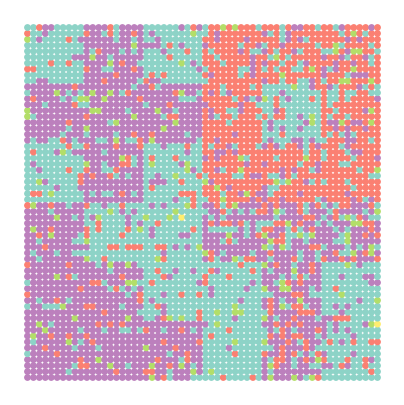

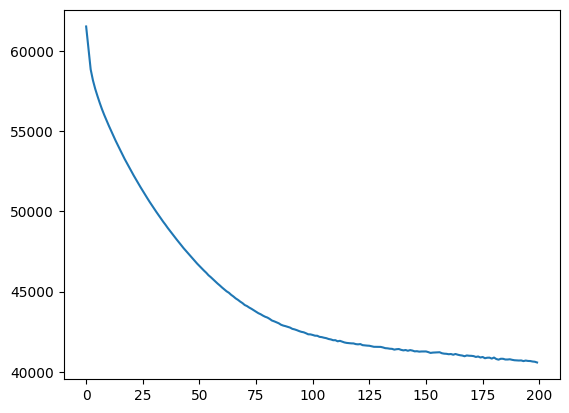

In [121]:
model = RSB(5)
topics = model.fit_predict(data[:, 3:], learning_rate=1e-2, n_steps=200, batch_size=128)
show_dataset(data, topics)
plt.show()
plt.plot(range(len(model.log_)), model.log_)
plt.show()